In [1]:
# Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Data 
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets

# Neural Net
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os

# **Loading Data**

In [2]:
testing_path = "../input/brain-tumor-classification-mri/Testing"
training_path = "../input/brain-tumor-classification-mri/Training"

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

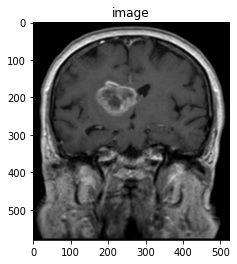

In [4]:
plt.title('image')
image = mpimg.imread("../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(12).jpg")
plt.imshow(image)
plt.show()

In [5]:
train_data = datasets.ImageFolder(training_path, transform=train_transforms)
test_data = datasets.ImageFolder(testing_path, transform=test_transforms)
train_data, val_data = torch.utils.data.random_split(train_data, [2500, 370])

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=32, shuffle=True)

# **Visualizing Data**

In [7]:

def imgshow(img):
    img = img/2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
images.shape

(32, 3, 250, 250)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


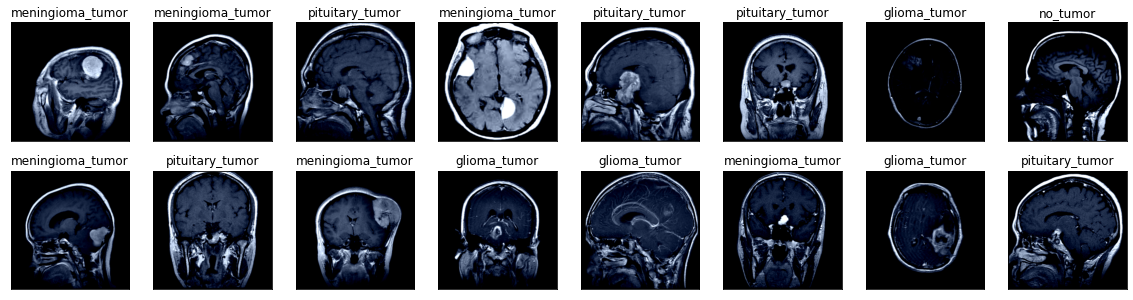

In [9]:
fig = plt.figure(figsize=(20, 5))

classes = test_data.classes
print(classes)

for i in np.arange(16):
    ax = fig.add_subplot(2, 8, i+1, xticks=[], yticks=[])
    imgshow(images[i])
    ax.set_title(classes[labels[i]])

# **Building The Network**

In [10]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.maxpool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(10, 10, 3)
        ##max
        self.fc1 = nn.Linear(61*61*10, 16)
        self.fc2 = nn.Linear(16, 4)
#       self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = x.view(-1,61*61*10)
        x = F.relu(self.fc1(x))
#       x = self.dropout(x)
        x = (self.fc2(x))
        return x
model = Net()
model

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=37210, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=4, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [12]:
epochs = 20 
min_loss = 100000

for i in range(epochs): 
    train_loss = 0 
    valid_loss = 0 
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        
        #back prop
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*labels.size(0)


    model.eval()
    for images, labels in valid_loader:
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()*labels.size(0)
        
    total_train_loss = train_loss/len(train_loader)
    total_valid_loss = valid_loss/len(valid_loader)
    
    print("\nEpoch {}, \ntraining loss: {} \nvalidation loss: {}".format(i, total_train_loss, total_valid_loss))
    if total_valid_loss < min_loss: 
        print("loss decreased {} --> {}".format(min_loss, total_valid_loss))
        torch.save(model.state_dict(), 'model.brain.pt')
        min_loss = total_valid_loss


Epoch 0, 
training loss: 39.79677853101416 
validation loss: 35.52801779905955
loss decreased 100000 --> 35.52801779905955

Epoch 1, 
training loss: 27.38861472093606 
validation loss: 73.27087354660034

Epoch 2, 
training loss: 23.862838099274455 
validation loss: 82.81364822387695

Epoch 3, 
training loss: 20.686024361018895 
validation loss: 26.27489197254181
loss decreased 35.52801779905955 --> 26.27489197254181

Epoch 4, 
training loss: 14.81794409057762 
validation loss: 20.137351751327515
loss decreased 26.27489197254181 --> 20.137351751327515

Epoch 5, 
training loss: 15.178315271305133 
validation loss: 24.476253032684326

Epoch 6, 
training loss: 11.578646430486366 
validation loss: 81.20498259862264

Epoch 7, 
training loss: 11.174630949768838 
validation loss: 18.29319304227829
loss decreased 20.137351751327515 --> 18.29319304227829

Epoch 8, 
training loss: 6.775161042620864 
validation loss: 31.242451469103496

Epoch 9, 
training loss: 5.527436978832076 
validation loss:

In [13]:
model.load_state_dict(torch.load('model.brain.pt'))

<All keys matched successfully>

# **Testing The Network**

In [14]:
test_loss = 0.0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))

model.eval()
for images, labels in test_loader:
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i]))) 
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
    
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
print(class_total, class_correct)

Test Loss: 0.081074

Test Accuracy of glioma_tumor: 29% (29/100)
Test Accuracy of meningioma_tumor: 76% (88/115)
Test Accuracy of no_tumor: 80% (84/105)
Test Accuracy of pituitary_tumor: 43% (32/74)

Test Accuracy (Overall): 59% (233/394)
[100.0, 115.0, 105.0, 74.0] [29.0, 88.0, 84.0, 32.0]
